In [565]:
import pandas
import numpy as np
import os
import shutil
from pathlib import Path
import json
import math
from PIL import Image, ImageDraw
import glob

import torch
import segmentation_models_pytorch as smp
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from segmentation_models_pytorch.metrics.functional import iou_score, get_stats


In [566]:
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")    

Using device: mps


In [567]:
SEED = 1

In [568]:
class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, multiclass=False):
        self.image_paths = list(image_paths)
        self.mask_paths  = list(mask_paths)
        self.transform = transform
        self.multiclass = multiclass

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, i):
        image = str(self.image_paths[i])
        mask = str(self.mask_paths[i])

        image = cv2.imread(image)
        if image is None:
            raise RuntimeError(f"cv2.imread failed for image: {image}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise RuntimeError(f"cv2.imread failed for mask: {mask}")

        if self.transform:
            try:
                out = self.transform(image=image, mask=mask)
            except Exception as e:
                raise RuntimeError(f"Augment failed for\n image: {image}\n mask: {mask}\n error: {e}")
            image, mask = out["image"], out["mask"]

        mask = torch.as_tensor(mask)
        mask = mask.long() if self.multiclass else mask.float()
        mask = (mask / 255.0).unsqueeze(0)  # to [0,1] and add channel dim
        return image, mask

In [569]:
Path().cwd() / "models"

PosixPath('/Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/u-net/models')

In [570]:
data_dir = Path().cwd().parent / "dataset"
if not data_dir.exists():
    raise FileNotFoundError(f"Data directory {data_dir} does not exist.")

images_dir = data_dir / "images"
if not images_dir.exists():
    raise FileNotFoundError(f"Images directory {images_dir} does not exist.")
labels_dir = data_dir / "labels"
if not labels_dir.exists():
    raise FileNotFoundError(f"Labels directory {labels_dir} does not exist.")
masks_dir = data_dir / "masks"
if not masks_dir.exists():
    raise FileNotFoundError(f"Masks directory {masks_dir} does not exist.")

models_dir = Path().cwd() / "models"
if not models_dir.exists():
    models_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Images directory: {images_dir}")
print(f"Labels directory: {labels_dir}")
print(f"Masks directory: {masks_dir}")
print(f"Models directory: {models_dir}")

Data directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset
Images directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset/images
Labels directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset/labels
Masks directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset/masks
Models directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/u-net/models


In [571]:
all_labels = set()

for jp in labels_dir.glob("*.json"):
    with open(jp, "r") as f:
        anno = json.load(f)
    for shape in anno.get("shapes", []):
        lbl = shape.get("label", "")
        all_labels.add(lbl)

print("Found labels:", all_labels)

Found labels: {'Nerve', 'nerve'}


In [572]:
CLASS_MAP = {"background": 0, "nerve": 1}

In [573]:
image_shapes = []
mask_shapes = []

for image in (images_dir.glob("*.png")):
    img = np.array(Image.open(image))
    image_shapes.append(img.shape[:2])  # (h, w)

for mask in masks_dir.glob("*.png"):
    m = np.array(Image.open(mask))
    mask_shapes.append(m.shape[:2])  # (h, w)

# check consistency
unique_image_shapes = set(image_shapes)
unique_mask_shapes = set(mask_shapes)

if len(unique_image_shapes) > 1:
    print("⚠️ Not all images have the same size:", unique_image_shapes)

if len(unique_mask_shapes) > 1:
    print("⚠️ Not all masks have the same size:", unique_mask_shapes)

if unique_image_shapes != unique_mask_shapes:
    print("⚠️ Image and mask sizes differ.")
else:
    print("✅ All images and masks have the same size:", unique_image_shapes.pop())

✅ All images and masks have the same size: (648, 864)


In [ ]:
img_set  = sorted(images_dir.glob("*.png"))
mask_set = sorted(masks_dir.glob("*.png"))

# build dictionary: {"1": Path("masks/1.png"), "2": Path("masks/2.png"), ...}
mask_dict = {m.stem: m for m in mask_set}

# pair image with its mask if stem matches
pairs = [(p, mask_dict[p.stem]) for p in img_set if p.stem in mask_dict]

print(f"Found {len(pairs)} matched pairs.")
img_stems  = {p.stem for p in images_dir.glob("*.png")}
mask_stems = {p.stem for p in masks_dir.glob("*.png")}

# Images without masks
missing_masks = img_stems - mask_stems
print(f"X {len(missing_masks)} images without masks:")
for s in sorted(missing_masks):
    print(" -", s)
    
missing_images = mask_stems - img_stems
print(f"X {len(missing_images)} masks without images:")
for s in sorted(missing_images):
    print(" -", s)
    


Found 300 matched pairs.
🟥 0 images without masks:
🟧 0 masks without images:


In [ ]:
imgs, masks = zip(*pairs)  # unzip into two lists

train_imgs, valtest_imgs, train_masks, valtest_masks = train_test_split(
    imgs, masks, test_size=0.3, random_state=SEED, shuffle=True
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    valtest_imgs, valtest_masks, test_size=0.5, random_state=SEED, shuffle=True
)

print(f"train images:{len(train_imgs)} \n val images:{len(val_imgs)} \n test images:{len(test_imgs)}")

210 45 45


In [576]:
pad_to_32 = A.PadIfNeeded(
    min_height=None, min_width=None,
    pad_height_divisor=32, pad_width_divisor=32,
    border_mode=cv2.BORDER_CONSTANT,
    fill=0,        # fill value for images
    position='center'
)

train_transform = A.Compose([
    pad_to_32,
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

eval_transform = A.Compose([
    pad_to_32,
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [577]:
train_ds = SegDataset(train_imgs, train_masks, transform=train_transform, multiclass=False)  # set True if >1 class
val_ds   = SegDataset(val_imgs,   val_masks,   transform=eval_transform,  multiclass=False)
test_ds  = SegDataset(test_imgs,  test_masks,  transform=eval_transform,  multiclass=False)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [602]:
sample_image, sample_mask = train_ds[0]  # Get processed sample
print(f"Processed image range: {sample_image.min():.3f} to {sample_image.max():.3f}")
print(f"Processed image shape: {sample_image.shape}")
print(f"Processed image dtype: {sample_image.dtype}")
print()
print(f"Processed mask range: {sample_mask.min():.3f} to {sample_mask.max():.3f}")
print(f"Processed mask shape: {sample_mask.shape}")
print(f"Processed mask dtype: {sample_mask.dtype}")

Processed image range: -2.118 to 2.640
Processed image shape: torch.Size([3, 672, 864])
Processed image dtype: torch.float32

Processed mask range: 0.000 to 1.000
Processed mask shape: torch.Size([1, 672, 864])
Processed mask dtype: torch.float32


In [579]:
imgs, masks = next(iter(train_loader))
print("Shapes:", imgs.shape, masks.shape)  # [B,3,H,W], [B,H,W]
H, W = imgs.shape[-2], imgs.shape[-1]
print("Divisible by 32:", H % 32 == 0, W % 32 == 0)
print("Mask uniques (sample):", masks[0].unique()[:10])

Shapes: torch.Size([1, 3, 672, 864]) torch.Size([1, 1, 672, 864])
Divisible by 32: True True
Mask uniques (sample): tensor([0., 1.])


In [580]:
# pick cache dirs inside your project (or anywhere you own)
hf_cache   = Path("./.cache/hf").resolve()
torch_cache= Path("./.cache/torch").resolve()
hf_cache.mkdir(parents=True, exist_ok=True)
torch_cache.mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"]   = str(hf_cache)     # for huggingface_hub
os.environ["TORCH_HOME"] = str(torch_cache) # for torch.hub

In [581]:
def batch_iou(logits: torch.Tensor, targets: torch.Tensor, thr: float = 0.5) -> torch.Tensor:
    with torch.no_grad():
        # logits: [B, 1, H, W]
        preds = (torch.sigmoid(logits) > thr)
        if preds.shape[1] == 1:
            preds = preds[:, 0]  # [B, H, W]
        preds = preds.to(torch.long)

        # targets should now be [B, 1, H, W] with values {0,1}
        if targets.dim() == 4 and targets.shape[1] == 1:
            targets = targets[:, 0]  # [B, H, W]
        targets = targets.to(torch.long)  # Already {0,1}

        tp, fp, fn, tn = get_stats(preds, targets, mode="binary", threshold=None)
        return iou_score(tp, fp, fn, tn, reduction="micro")

In [582]:
model = smp.Linknet(encoder_name="resnet34", encoder_weights="imagenet",in_channels=3, classes=1).to(device)

# Binary losses/metrics
loss_fn = smp.losses.DiceLoss(mode="binary")   # or nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/Users/ratchanonkhongsawi/anaconda3/envs/monai_env/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading resnet34 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)


In [583]:
positive_pixels = (masks > 0).sum()
total_pixels = masks.numel()
positive_ratio = positive_pixels / total_pixels
print(f"Positive class ratio: {positive_ratio:.4f}")

Positive class ratio: 0.0068


In [587]:
def run_epoch(loader, train=True, loss_fn=loss_fn, optimizer=optimizer):
    if train:
        model.train()
    else:
        model.eval()

    tot_loss, tot_iou, n = 0.0, 0.0, 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        if train:
            optimizer.zero_grad()

        logits = model(imgs)
        loss   = loss_fn(logits, masks)
        iou    = batch_iou(logits, masks)

        if train:
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        tot_loss += loss.item() * bs
        tot_iou  += iou.item()  * bs
        n += bs

    return tot_loss / n, tot_iou / n

best_val = float("inf")
for epoch in range(1, 21):
    tr_loss, tr_iou = run_epoch(train_loader, train=True)
    va_loss, va_iou = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} IoU {tr_iou:.3f} | val loss {va_loss:.4f} IoU {va_iou:.3f}")

    # simple checkpoint on best val loss
    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), "linknet_best.pt")

Epoch 01 | train loss 0.8749 IoU 0.131 | val loss 0.9789 IoU 0.011
Epoch 02 | train loss 0.6189 IoU 0.288 | val loss 0.8554 IoU 0.083
Epoch 03 | train loss 0.5254 IoU 0.351 | val loss 0.8627 IoU 0.101
Epoch 04 | train loss 0.4559 IoU 0.409 | val loss 0.7764 IoU 0.139
Epoch 05 | train loss 0.4416 IoU 0.429 | val loss 0.7601 IoU 0.178
Epoch 06 | train loss 0.4178 IoU 0.452 | val loss 0.5788 IoU 0.306
Epoch 07 | train loss 0.4670 IoU 0.408 | val loss 0.8390 IoU 0.118
Epoch 08 | train loss 0.4346 IoU 0.434 | val loss 0.7662 IoU 0.184
Epoch 09 | train loss 0.3745 IoU 0.490 | val loss 0.7042 IoU 0.224
Epoch 10 | train loss 0.3833 IoU 0.480 | val loss 0.6518 IoU 0.250
Epoch 11 | train loss 0.3716 IoU 0.494 | val loss 0.7278 IoU 0.202
Epoch 12 | train loss 0.4148 IoU 0.456 | val loss 0.6971 IoU 0.229
Epoch 13 | train loss 0.4087 IoU 0.461 | val loss 0.6408 IoU 0.275
Epoch 14 | train loss 0.3336 IoU 0.524 | val loss 0.7951 IoU 0.149
Epoch 15 | train loss 0.3224 IoU 0.536 | val loss 0.5370 IoU 0

In [588]:
# load best and evaluate on test set
model.load_state_dict(torch.load("linknet_best.pt", map_location=device))
te_loss, te_iou = run_epoch(test_loader, train=False)
print(f"TEST | loss {te_loss:.4f} IoU {te_iou:.3f}")

TEST | loss 0.4642 IoU 0.401


In [589]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def _to_numpy_image(image):
    # image: np [H,W,3] or torch [C,H,W]
    if isinstance(image, torch.Tensor):
        if image.ndim == 3 and image.shape[0] in (1,3):   # [C,H,W] -> [H,W,C]
            image = image.detach().cpu().permute(1,2,0).numpy()
        else:
            image = image.detach().cpu().numpy()
    if image.ndim == 2:  # grayscale -> RGB
        image = np.stack([image]*3, axis=-1)
    # scale to uint8 if needed
    if image.dtype != np.uint8:
        im = image.astype(np.float32)
        if im.max() <= 1.0:
            im = im * 255.0
        image = np.clip(im, 0, 255).astype(np.uint8)
    return image

def _to_2d_prob(logits):
    # logits: torch or np; returns numpy float32 [H,W] in [0,1]
    if isinstance(logits, torch.Tensor):
        x = torch.sigmoid(logits.detach().cpu().float())
        if x.ndim == 4:         # [B,1,H,W] or [B,H,W] -> take first channel
            if x.shape[1] == 1: x = x[:,0]
            x = x[0]
        elif x.ndim == 3:       # [1,H,W] or [H,W,C]
            if x.shape[0] == 1: x = x[0]
        # now expect [H,W]
        prob = x.numpy()
    else:
        prob = logits
        if prob.ndim == 3 and prob.shape[0] == 1:
            prob = prob[0]
        # if logits not passed through sigmoid, do it
        if prob.max() > 1.0 or prob.min() < 0.0:
            prob = 1.0 / (1.0 + np.exp(-prob))
    return prob.astype(np.float32)

def show_overlay(image, logits, alpha=0.5, thr=0.5, color=(255, 0, 0)):
    """
    image: np [H,W,3] or torch [C,H,W]  (RGB)
    logits: torch or np; shapes: [B,1,H,W], [1,H,W], [H,W]
    alpha: overlay transparency
    thr:   probability threshold for binary mask
    color: RGB tuple for mask regions
    """
    image = _to_numpy_image(image)              # [H,W,3] uint8
    H, W = image.shape[:2]
    prob = _to_2d_prob(logits)                  # [h,w] float32 in [0,1]

    # If mask size mismatches, resize with NEAREST (keeps boundaries)
    if prob.shape[0] != H or prob.shape[1] != W:
        if isinstance(logits, torch.Tensor):
            t = torch.from_numpy(prob).unsqueeze(0).unsqueeze(0)  # [1,1,h,w]
            t = F.interpolate(t, size=(H, W), mode="nearest")
            prob = t[0,0].numpy()
        else:
            # numpy-only nearest resize (manual, no cv2 needed)
            yy = (np.linspace(0, prob.shape[0]-1, H)).round().astype(int)
            xx = (np.linspace(0, prob.shape[1]-1, W)).round().astype(int)
            prob = prob[yy][:, xx]

    mask = (prob > thr).astype(np.uint8)        # [H,W] {0,1}

    # Build color overlay and blend (in RGB)
    overlay = image.copy().astype(np.float32)
    color_arr = np.array(color, dtype=np.float32).reshape(1,1,3)
    overlay[mask == 1] = color_arr

    blended = (image.astype(np.float32) * (1 - alpha) +
               overlay * alpha).astype(np.uint8)

    # plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Pred Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay");   plt.imshow(blended); plt.axis("off")
    plt.show()

In [599]:
img[1]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], shape=(864, 3), dtype=uint8)

In [ ]:
pred = model.predict(imgs.to(device))

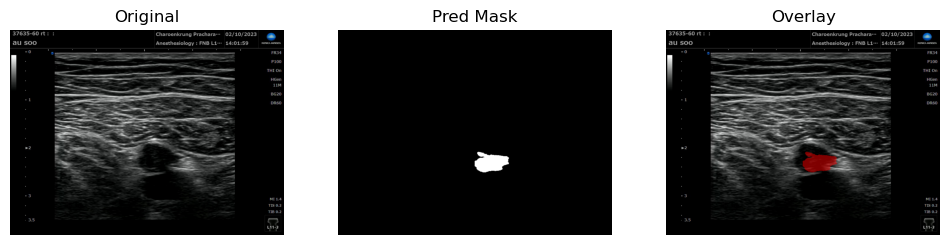

In [601]:
show_overlay(img, pred, alpha=0.5, thr=0.5)